In [1]:
# Step 1: Setup & Imports
from google.colab import files
uploaded = files.upload()

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns


Saving data.csv to data.csv


In [2]:
# Step 2: Load the CSV
df = pd.read_csv('data.csv', encoding='ISO-8859-1')
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
# Step 3: Clean Data
print("Initial shape:", df.shape)

# Drop missing Customer IDs
df.dropna(subset=['CustomerID'], inplace=True)

# Remove negative or zero quantities
df = df[df['Quantity'] > 0]

# Remove rows with zero or negative UnitPrice
df = df[df['UnitPrice'] > 0]

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

print("After cleaning:", df.shape)
df.head()


Initial shape: (541909, 8)
After cleaning: (397884, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [4]:
# Step 4: Create SQLite database
conn = sqlite3.connect('ecommerce.db')

# Push cleaned data to SQL
df.to_sql('transactions', conn, if_exists='replace', index=False)

# Check the first few rows from SQL
pd.read_sql_query("SELECT * FROM transactions LIMIT 5", conn)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [5]:
# Step 5: Basic check
query = """
SELECT Country, COUNT(DISTINCT CustomerID) as unique_customers, SUM(TotalPrice) as total_revenue
FROM transactions
GROUP BY Country
ORDER BY total_revenue DESC
LIMIT 10;
"""
pd.read_sql_query(query, conn)


,Country,unique_customers,total_revenue
0,United Kingdom,3920,7.308392e+06
1,Netherlands,9,2.854463e+05
2,EIRE,3,2.655459e+05
3,Germany,94,2.288671e+05
4,France,87,2.090240e+05
5,Australia,9,1.385213e+05
6,Spain,30,6.157711e+04
7,Switzerland,21,5.644395e+04
8,Belgium,25,4.119634e+04
9,Sweden,8,3.837833e+04


##1️⃣ Monthly Revenue
###Tracks how much the company earned each month.

In [6]:
query_monthly_revenue = """
SELECT
    strftime('%Y-%m', InvoiceDate) AS month,
    ROUND(SUM(TotalPrice), 2) AS monthly_revenue
FROM transactions
GROUP BY month
ORDER BY month;
"""
monthly_revenue = pd.read_sql_query(query_monthly_revenue, conn)
monthly_revenue.head()


,month,monthly_revenue
0,2010-12,572713.89
1,2011-01,569445.04
2,2011-02,447137.35
3,2011-03,595500.76
4,2011-04,469200.36


## 📊 Visualization:

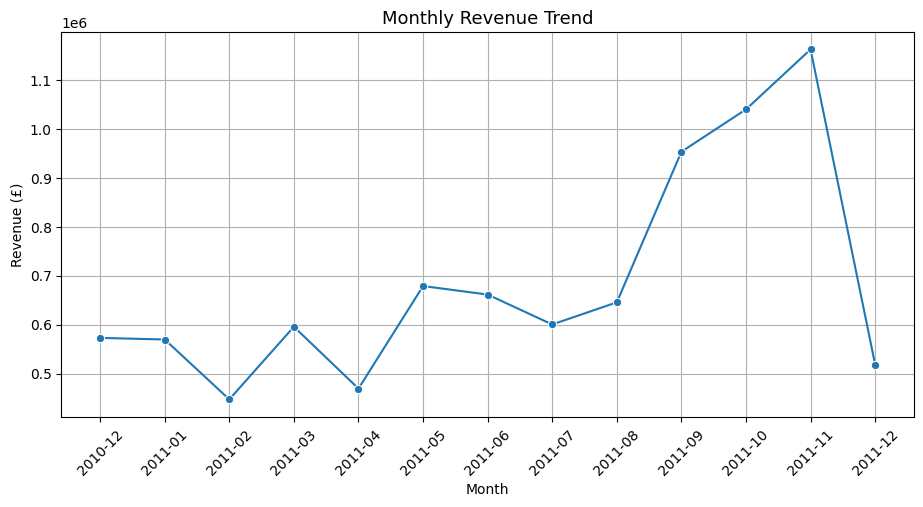

In [8]:
plt.figure(figsize=(11,5))
sns.lineplot(data=monthly_revenue, x='month', y='monthly_revenue', marker='o')
plt.title('Monthly Revenue Trend', fontsize=13)
plt.xticks(rotation=45)
plt.ylabel('Revenue (£)')
plt.xlabel('Month')
plt.grid(True)
plt.show()


## 2️⃣ Monthly Growth Rate

### Shows how fast sales are growing month to month.

In [9]:
query_growth_rate = """
WITH revenue_cte AS (
  SELECT
      strftime('%Y-%m', InvoiceDate) AS month,
      SUM(TotalPrice) AS revenue
  FROM transactions
  GROUP BY month
)
SELECT
    month,
    revenue,
    ROUND(
      (revenue - LAG(revenue) OVER (ORDER BY month)) * 100.0 /
       LAG(revenue) OVER (ORDER BY month), 2
    ) AS growth_rate
FROM revenue_cte;
"""
growth_rate = pd.read_sql_query(query_growth_rate, conn)
growth_rate.head()


,month,revenue,growth_rate
0,2010-12,572713.890,NaN
1,2011-01,569445.040,-0.57
2,2011-02,447137.350,-21.48
3,2011-03,595500.760,33.18
4,2011-04,469200.361,-21.21


## 📊 Visualization:

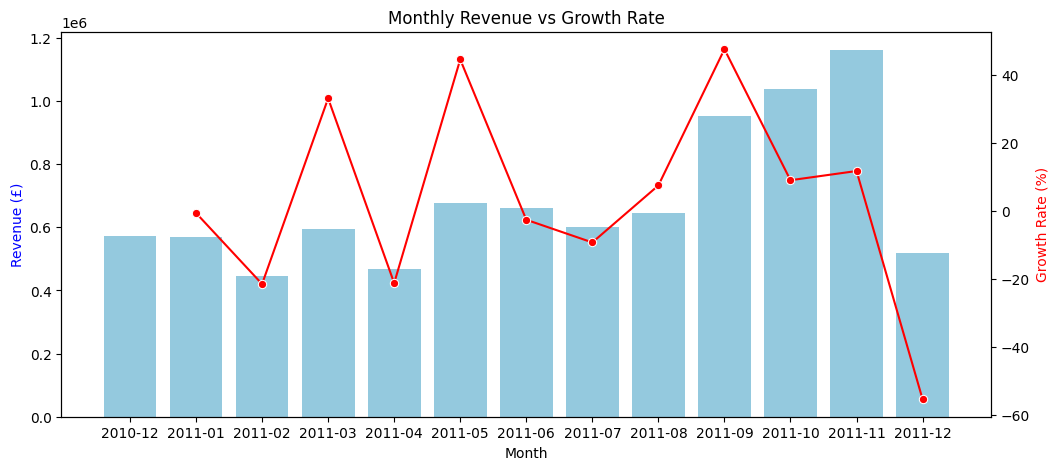

In [10]:
fig, ax1 = plt.subplots(figsize=(12,5))

ax2 = ax1.twinx()
sns.barplot(data=growth_rate, x='month', y='revenue', ax=ax1, color='skyblue')
sns.lineplot(data=growth_rate, x='month', y='growth_rate', ax=ax2, color='red', marker='o')

ax1.set_xlabel('Month')
ax1.set_ylabel('Revenue (£)', color='blue')
ax2.set_ylabel('Growth Rate (%)', color='red')
plt.title('Monthly Revenue vs Growth Rate')
plt.xticks(rotation=45)
plt.show()


## 3️⃣ Top 10 Best-Selling Products

### Finds products contributing the most to total revenue.

In [11]:
query_top_products = """
SELECT
    Description AS product,
    ROUND(SUM(TotalPrice), 2) AS revenue
FROM transactions
GROUP BY product
ORDER BY revenue DESC
LIMIT 10;
"""
top_products = pd.read_sql_query(query_top_products, conn)
top_products


,product,revenue
0,"PAPER CRAFT , LITTLE BIRDIE",168469.60
1,REGENCY CAKESTAND 3 TIER,142592.95
2,WHITE HANGING HEART T-LIGHT HOLDER,100448.15
3,JUMBO BAG RED RETROSPOT,85220.78
4,MEDIUM CERAMIC TOP STORAGE JAR,81416.73
5,POSTAGE,77803.96
6,PARTY BUNTING,68844.33
7,ASSORTED COLOUR BIRD ORNAMENT,56580.34
8,Manual,53779.93
9,RABBIT NIGHT LIGHT,51346.20


## 📊 Visualization

/tmp/ipython-input-2540397250.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_products, y='product', x='revenue', palette='viridis')


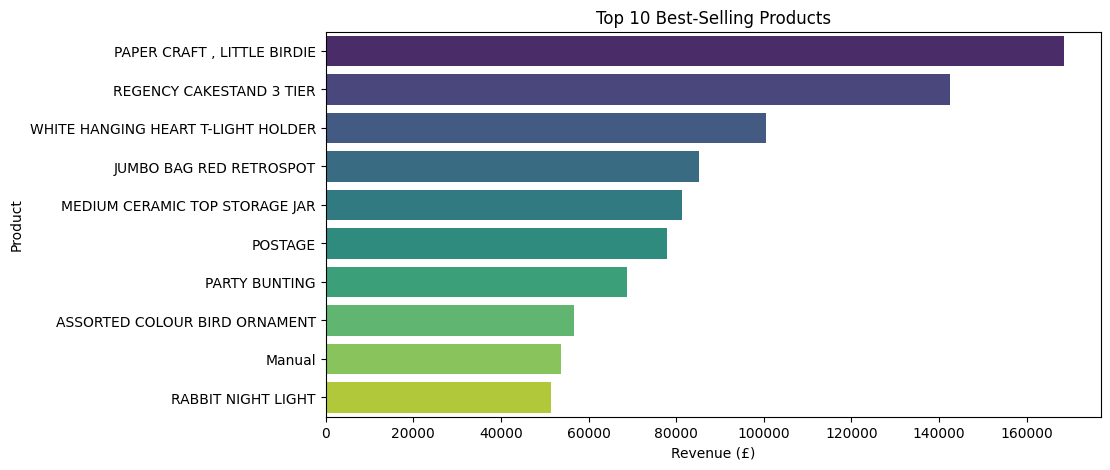

In [12]:
plt.figure(figsize=(10,5))
sns.barplot(data=top_products, y='product', x='revenue', palette='viridis')
plt.title('Top 10 Best-Selling Products')
plt.xlabel('Revenue (£)')
plt.ylabel('Product')
plt.show()


## 4️⃣ Top 10 Countries by Revenue


In [13]:
query_country_revenue = """
SELECT
    Country,
    ROUND(SUM(TotalPrice), 2) AS total_revenue
FROM transactions
GROUP BY Country
ORDER BY total_revenue DESC
LIMIT 10;
"""
country_revenue = pd.read_sql_query(query_country_revenue, conn)
country_revenue


,Country,total_revenue
0,United Kingdom,7308391.55
1,Netherlands,285446.34
2,EIRE,265545.90
3,Germany,228867.14
4,France,209024.05
5,Australia,138521.31
6,Spain,61577.11
7,Switzerland,56443.95
8,Belgium,41196.34
9,Sweden,38378.33


## 📊 Visualization:

/tmp/ipython-input-1828341383.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=country_revenue, x='total_revenue', y='Country', palette='cool')


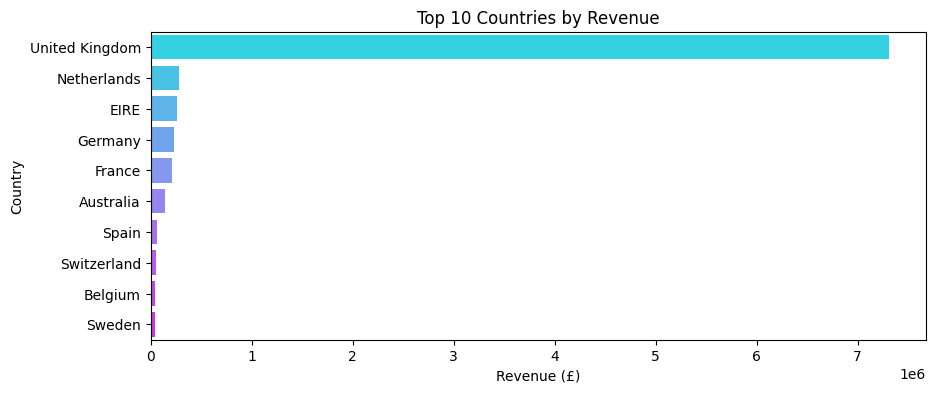

In [17]:
plt.figure(figsize=(10,4))
sns.barplot(data=country_revenue, x='total_revenue', y='Country', palette='cool')
plt.title('Top 10 Countries by Revenue')
plt.xlabel('Revenue (£)')
plt.ylabel('Country')
plt.show()


## 5️⃣ Top 10 Customers by Spending

In [18]:
query_top_customers = """
SELECT
    CustomerID,
    ROUND(SUM(TotalPrice), 2) AS total_spent
FROM transactions
GROUP BY CustomerID
ORDER BY total_spent DESC
LIMIT 10;
"""
top_customers = pd.read_sql_query(query_top_customers, conn)
top_customers


,CustomerID,total_spent
0,14646.0,280206.02
1,18102.0,259657.30
2,17450.0,194550.79
3,16446.0,168472.50
4,14911.0,143825.06
5,12415.0,124914.53
6,14156.0,117379.63
7,17511.0,91062.38
8,16029.0,81024.84
9,12346.0,77183.60


## 📊 Visualization:

/tmp/ipython-input-2691115952.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_customers, x='CustomerID', y='total_spent', palette='mako')


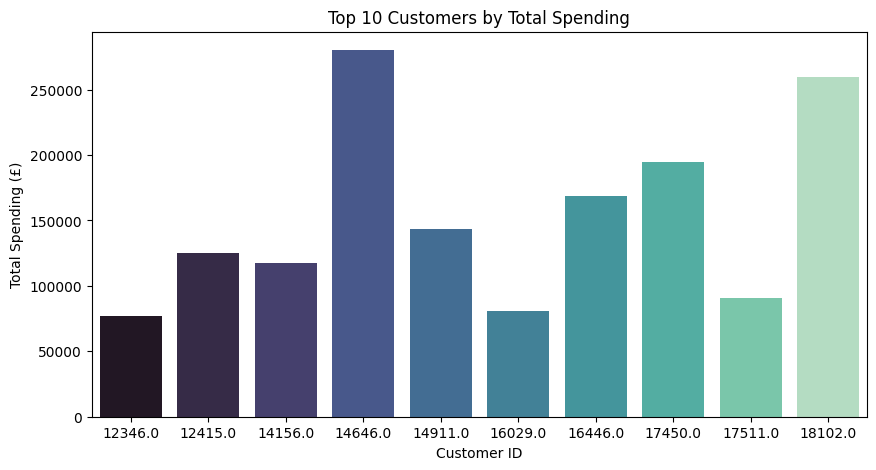

In [19]:
plt.figure(figsize=(10,5))
sns.barplot(data=top_customers, x='CustomerID', y='total_spent', palette='mako')
plt.title('Top 10 Customers by Total Spending')
plt.xlabel('Customer ID')
plt.ylabel('Total Spending (£)')
plt.show()
